In [1]:
from voc_data_loader import image_loader, voc_meta
%matplotlib inline

from models import rpn, resnet, rpn_utils, training_params

import matplotlib
import numpy
import matplotlib.pyplot as plt

In [2]:
loader = image_loader("/home/cadams/DLPlayground/model_voc07_test/VOC2007")
meta = voc_meta("/home/cadams/DLPlayground/model_voc07_test/VOC2007")

In [3]:
batch_size = 1
data, labels, boxes = loader.get_next_val_batch(batch_size, mode="class")

This is the data image shape

In [4]:
print data.shape

(1, 512, 512, 3)


Here is what the bounding boxes look like

In [5]:
print boxes

[[[  19.   54.  444.  467.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]]]


And lastly, here are the labels (one-hot format):

In [6]:
print labels

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]


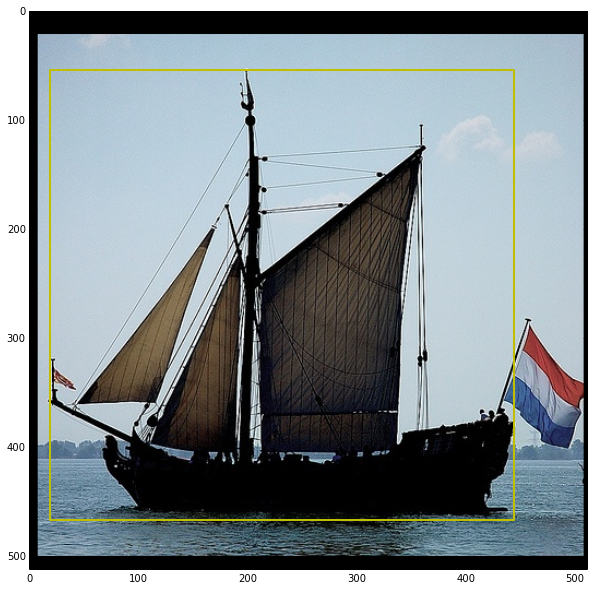

In [7]:
for i in range(batch_size):
    fig,ax = plt.subplots(figsize=(10,10))
    plt.imshow(data[i])
    for j_roi in range(len(boxes[i])):
        box = boxes[i][j_roi]
        rect = matplotlib.patches.Rectangle((box[0],box[1]),
                                            box[2] - box[0],
                                            box[3] - box[1],
                                            linewidth=2,
                                            edgecolor='y',
                                            facecolor='none')
#         ax.text(box[0], box[1],class_name, fontsize=15)
        ax.add_patch(rect)
    plt.show()


Now set up the tensorflow interface to do forward pass prediction

In [8]:
import tensorflow as tf
import numpy


Define parameters for the convolutional network and the RPN:

In [9]:

# Use a resnet for the convolutional step:
conv_params = resnet.resnet_params()
conv_params.network_params()['n_blocks'] = 8
conv_params.network_params()['include_final_classifier'] = False
conv_params.network_params()['n_classes'] = 10
conv_params.network_params()['n_initial_filters'] = 12
conv_params.network_params()['downsample_interval'] = 2
conv_params.network_params()['initial_stride'] = 2
conv_params.network_params()['initial_kernel'] = 5
conv_params.network_params()['bottleneck'] = False
conv_params.network_params()['weight_decay'] = 1E-3
conv_params.network_params()['activation'] = 'softmax'
conv_params.network_params()['restore_file'] = "/home/cadams/DLPlayground/model_voc07_test/logs/rpn_resnet/resnet_ik_5_nb_8_di_2_is_2_B_False_nf_12//checkpoints/save-7000"

# Set up the network we want to test:
rpn_params = rpn.rpn_params()
rpn_params.network_params()['n_anchors_per_box'] = 9
rpn_params.network_params()['weight_decay'] = 1E-3
rpn_params.network_params()['n_selected_regressors'] = 56

LOGDIR="logs/rpn_resnet/resnet_ik_5_nb_8_di_2_is_2_B_False_nf_12/"

Next, set up the trained network:

In [10]:
# Set up the graph:

tf.reset_default_graph()

N_MAX_TRUTH = 10
# Set input data and label for training
data_tensor = tf.placeholder(tf.float32, [None, 512,512,3], name='x')
label_tensor = tf.placeholder(tf.float32, [None, 20], name='labels')
box_label = tf.placeholder(tf.float32, [N_MAX_TRUTH, 4], name='truth_anchors')

# Let the convolutional part of the network be independant
# of the classifiers:
with tf.variable_scope("ResNet"):

    conv_net = resnet.resnet(conv_params)
    final_conv_layer = conv_net.build_network(input_tensor=data_tensor,
                                              is_training=False)    


names = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="ResNet")
n = final_conv_layer.get_shape().as_list()[1]

RPN = rpn.rpn(rpn_params)
classifier, regressor = RPN.build_rpn(final_conv_layer=final_conv_layer, 
                                          is_training=True)

# The previous functions work with batch_size == 1 to allow interface with
# other code, particularly for the conv nets.
# 
# Here, squeeze the batch size out to get just the raw shapes:
classifier = tf.squeeze(classifier)
regressor = tf.squeeze(regressor)


# Get a set of reference anchors:

n_anchors_x = final_conv_layer.get_shape().as_list()[1]
n_anchors_y = final_conv_layer.get_shape().as_list()[2]
effective_stride_x = data_tensor.get_shape().as_list()[1] / n_anchors_x
effective_stride_y = data_tensor.get_shape().as_list()[2] / n_anchors_y
n_anchors_x -= 2
n_anchors_y -= 2

n_anchors_total = n_anchors_x*n_anchors_y*rpn_params.network_params()['n_anchors_per_box']

classifier = tf.reshape(classifier, (n_anchors_total, 2))
regressor = tf.reshape(regressor, (n_anchors_total, 4))


_base_anchors = rpn_utils.generate_anchors(base_size = 16*3, 
                                           ratios = [0.5, 1, 2.0], 
                                           scales = [2,4,6])
# _base_anchors = rpn_utils.generate_anchors(base_size = 16*3, 
#                                            ratios = [1], 
#                                            scales = [4, 8])    

_anchors = rpn_utils.pad_anchors(_base_anchors,
                                n_tiles_x=n_anchors_x, 
                                n_tiles_y=n_anchors_y, 
                                step_size_x=effective_stride_x, 
                                step_size_y=effective_stride_y)

# # For debugging only: force the output of the regressor to a deterministic value:
# regressor = tf.placeholder(tf.float32, (8100, 4), name = "fake_regressor")
# numpy.random.seed(0)
# _fake_regressor = numpy.random.rand(8100, 4)
# _fake_regressor[:,2] *= 0.25
# _fake_regressor[:,3] *= 0.25

rpn_utils.boxes_whctrs_to_minmax(_anchors, in_place=True)

# Anchors are now in min/max format and will always be 
# assumed to be in min/max format

anchors = tf.placeholder(tf.float32, _anchors.shape, name="anchors")





In [11]:
# other_names = []
# for n in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
#     if n not in names:
#         other_names.append(n)
# print other_names

# # print names


In [12]:
LOGDIR = "logs/rpn_resnet/" + "/" + RPN.full_name() + "/"
print LOGDIR

logs/rpn_resnet//rpn/


Restore the network:

In [48]:

# checkpoint_file = LOGDIR + '/checkpoints/' + "save-50"
latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
print latest_checkpoint
sess = tf.InteractiveSession()        
all_saver = tf.train.Saver()
all_saver.restore(sess, latest_checkpoint)

logs/rpn_resnet//rpn//checkpoints/save-20000
INFO:tensorflow:Restoring parameters from logs/rpn_resnet//rpn//checkpoints/save-20000


Run a forward pass of the network:

In [101]:
data, labels, boxes = loader.get_next_train_batch(1, mode='class')
# labels = numpy.squeeze(labels)
# boxes = numpy.squeeze(boxes)
cls, rgs = sess.run(
                [classifier, regressor], 
                feed_dict={data_tensor : data,
#                            label_tensor: labels
                           # regressor : _fake_regressor, 
#                            anchors : _anchors
                          })

print cls.shape
print rgs.shape

threshold = 0.5


pos_indexes = cls[:,1] > threshold
print "Number of positive selections: {}".format(numpy.sum(pos_indexes))
if numpy.sum(pos_indexes > 0):
    print pos_indexes.shape
    # print cls[pos_indexes].shape
    # print rgs[pos_indexes].shape

    pos_rgs = rgs[pos_indexes]
    pos_cls = cls[pos_indexes]
    pos_anchors = _anchors[pos_indexes]

    rgs_boxes = rpn_utils.boxes_regcoord_to_whctrs(pos_rgs, pos_anchors)

    fig,ax = plt.subplots(figsize=(10,10))
    plt.imshow(data[0])

    for j_roi in range(len(rgs_boxes)):
        box = rgs_boxes[j_roi]
        print box
        rect = matplotlib.patches.Rectangle((box[0] - 0.5*box[2],
                                             box[1] - 0.5*box[3]),
                                            box[0] + 0.5*box[2],
                                            box[1] + 0.5*box[3],
                                            linewidth=2,
                                            edgecolor='y',
                                            facecolor='none')
    #         ax.text(box[0], box[1],class_name, fontsize=15)
        ax.add_patch(rect)
    plt.show()



(8100, 2)
(8100, 4)
Number of positive selections: 0


In [15]:

pos_indexes = numpy.where(cls[:,1] > 0.99999)[0]
pos_boxes = rgs[pos_indexes]
pos_anchors = _anchors[pos_indexes]
print pos_indexes
print pos_anchors
print pos_boxes

[]
[]
[]


In [16]:
print data.shape

(1, 512, 512, 3)


Draw the output of this forward pass: